In [ ]:
!pip install tensorflow pandas nltk tqdm matplotlib

In [ ]:
import os
import re
import pickle
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
image_path = '/content/MyImages'
data = pd.read_csv("/content/drive/MyDrive/BASE_DIR/cleaned_captions.txt")

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import shutil

# Source folder on Drive
src = '/content/drive/MyDrive/BASE_DIR/Images'

# Destination folder in Colab local storage
dst = '/content/MyImages'

# Copy folder
shutil.copytree(src, dst)


'/content/MyImages'

In [ ]:
def text_preprocessing_df(df, caption_col='caption'):
    # lower, remove non-letters, collapse spaces, remove 1-char words, add start/end tokens
    def clean_text(s):
        s = s.lower()
        s = re.sub(r'[^a-z\s]', ' ', s)   # keep a-z and spaces
        s = re.sub(r'\s+', ' ', s).strip()
        words = [w for w in s.split() if len(w) > 1]  # drop single-letter tokens
        return 'startseq ' + ' '.join(words) + ' endseq'
    df = df.copy()
    df[caption_col] = df[caption_col].astype(str).apply(clean_text)
    return df

data = text_preprocessing_df(data, 'caption')
display(data.head())  # quick check

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...


In [ ]:
def extract_nouns_from_caption(caption):
    # caption already preprocessed into words; remove start/end tokens for pos tagging
    text = caption.replace('startseq','').replace('endseq','').strip()
    toks = nltk.word_tokenize(text)
    tags = nltk.pos_tag(toks)
    nouns = [w for w,t in tags if t.startswith('NN') and len(w) > 1]
    return nouns

# Build noun frequency
noun_counter = Counter()
for cap in tqdm(data['caption'].tolist(), desc='Counting nouns'):
    nouns = extract_nouns_from_caption(cap)
    noun_counter.update(nouns)

# Keep top-N nouns as answer classes
TOP_ANSWERS = 200   # tune this (200 is a reasonable start)
most_common = [w for w,_ in noun_counter.most_common(TOP_ANSWERS)]
answer_set = set(most_common)
print(f"Using top {len(most_common)} nouns as answers. Example answers: {most_common[:15]}")

Counting nouns: 100%|██████████| 40450/40450 [00:15<00:00, 2583.39it/s]

Using top 200 nouns as answers. Example answers: ['dog', 'man', 'woman', 'boy', 'girl', 'people', 'water', 'dogs', 'shirt', 'ball', 'grass', 'person', 'child', 'front', 'field']


In [ ]:
# Build QA dataframe
qa_rows = []
for _, row in tqdm(data.iterrows(), total=len(data), desc='Building QA rows'):
    img = row['image']
    cap = row['caption']
    nouns = extract_nouns_from_caption(cap)
    # choose first noun that's in top answers
    ans = next((n for n in nouns if n in answer_set), None)
    if ans:
        qa_rows.append({'image': img, 'question': 'what is in the image ?', 'answer': ans})

Building QA rows: 100%|██████████| 40450/40450 [00:19<00:00, 2036.14it/s]


In [ ]:
vqa_df = pd.DataFrame(qa_rows)
print("Total QA pairs:", len(vqa_df))
vqa_df = vqa_df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

Total QA pairs: 39551


In [ ]:
images = vqa_df['image'].unique().tolist()
nimages = len(images)
split_idx = int(0.85 * nimages)
train_images = images[:split_idx]
val_images = images[split_idx:]

train_df = vqa_df[vqa_df['image'].isin(train_images)].reset_index(drop=True)
val_df = vqa_df[vqa_df['image'].isin(val_images)].reset_index(drop=True)
print("train pairs:", len(train_df), "val pairs:", len(val_df))

train pairs: 33735 val pairs: 5816


In [ ]:
# ---------------- STEP 4: Tokenize questions and build answer index ----------
# Question tokenizer
question_tokenizer = Tokenizer(oov_token='UNK')
question_tokenizer.fit_on_texts(train_df['question'].tolist() + val_df['question'].tolist())
q_vocab_size = len(question_tokenizer.word_index) + 1
print("Question vocab size:", q_vocab_size)

# Answer -> index mapping for classification (only top answers)
answers = sorted(list(answer_set))
answer2idx = {a:i for i,a in enumerate(answers)}
idx2answer = {i:a for a,i in answer2idx.items()}
num_answers = len(answer2idx)
print("Number of answer classes:", num_answers)

# Compute max question length
max_q_len = max(len(q.split()) for q in train_df['question'].tolist() + val_df['question'].tolist())
print("Max question length:", max_q_len)

Question vocab size: 7
Number of answer classes: 200
Max question length: 6


In [ ]:
cnn_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))

# Save/load feature dictionary to avoid recompute
feats_file = '/content/drive/MyDrive/BASE_DIR/image_features_vgg16.pkl'  # set path
if os.path.exists(feats_file):
    print("Loading precomputed image features...")
    with open(feats_file, 'rb') as f:
        image_features = pickle.load(f)
else:
    print("Extracting image features with VGG16...")
    image_features = {}
    unique_imgs = set(vqa_df['image'].unique().tolist())
    for img_name in tqdm(unique_imgs, desc='Extracting features'):
        p = os.path.join(image_path, img_name)
        if not os.path.exists(p):
            # if path missing: skip (or handle)
            print("Missing image:", p)
            continue
        img = load_img(p, target_size=(224,224))
        arr = img_to_array(img)
        x = np.expand_dims(arr, axis=0)
        x = vgg_preprocess(x)
        feat = cnn_model.predict(x, verbose=0)   # shape (1,512)
        image_features[img_name] = feat[0]
    # save dict
    with open(feats_file, 'wb') as f:
        pickle.dump(image_features, f)
    print("Saved features to", feats_file)

# quick check
print("Example feature vector length:", next(iter(image_features.values())).shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Extracting image features with VGG16...


Extracting features: 100%|██████████| 8090/8090 [10:18<00:00, 13.07it/s]

Saved features to /content/drive/MyDrive/BASE_DIR/image_features_vgg16.pkl
Example feature vector length: (512,)


In [ ]:
def vqa_generator(df, image_features, question_tokenizer, answer2idx, batch_size=32, max_q_len=20):
    n = len(df)
    while True:
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, n, batch_size):
            batch = df.iloc[i:i+batch_size]
            actual_batch = len(batch)
            X_img = np.zeros((actual_batch, 512), dtype='float32')
            X_q = np.zeros((actual_batch, max_q_len), dtype='int32')
            y = np.zeros((actual_batch, num_answers), dtype='float32')
            for j, (_, row) in enumerate(batch.iterrows()):
                img_name = row['image']
                if img_name not in image_features:
                    # zero vector if missing
                    feat = np.zeros((512,), dtype='float32')
                else:
                    feat = image_features[img_name]
                X_img[j] = feat
                seq = question_tokenizer.texts_to_sequences([row['question']])[0]
                seq = seq[:max_q_len]
                X_q[j, :len(seq)] = seq
                ans = row['answer']
                if ans in answer2idx:
                    y[j, answer2idx[ans]] = 1.0
            yield (X_img, X_q), y

In [ ]:
embedding_dim = 300
lstm_units = 512

# Image branch
img_input = Input(shape=(512,), name='image_input')   # precomputed 512-d features
img_dense = Dense(512, activation='relu')(img_input)
img_dense = Dropout(0.5)(img_dense)

# Question branch
q_input = Input(shape=(max_q_len,), name='question_input')
q_embed = Embedding(input_dim=q_vocab_size, output_dim=embedding_dim, mask_zero=True)(q_input)
q_lstm = LSTM(lstm_units)(q_embed)
q_dense = Dropout(0.5)(q_lstm)

# Fuse
merged = Concatenate()([img_dense, q_dense])
x = Dense(1024, activation='relu')(merged)
x = Dropout(0.5)(x)
output = Dense(num_answers, activation='softmax')(x)

model = Model(inputs=[img_input, q_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_input      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 6, 300)    │      2,100 │ question_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 6)         │          0 │ question_input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    262,656 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 512)       │  1,665,024 │ embedding_2[0][0… │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 512)       │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1024)      │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1024)      │  1,049,600 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1024)      │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 200)       │    205,000 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,184,380 (12.15 MB)

 Trainable params: 3,184,380 (12.15 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

BATCH_SIZE = 64
EPOCHS = 10

# Wrap train generator into tf.data.Dataset
train_ds = tf.data.Dataset.from_generator(
    lambda: vqa_generator(train_df, image_features, question_tokenizer, answer2idx,
                          batch_size=BATCH_SIZE, max_q_len=max_q_len),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 512), dtype=tf.float32),     # image features
            tf.TensorSpec(shape=(None, max_q_len), dtype=tf.int32)  # question sequences
        ),
        tf.TensorSpec(shape=(None, num_answers), dtype=tf.float32)  # one-hot answers
    )
)

# Wrap val generator into tf.data.Dataset
val_ds = tf.data.Dataset.from_generator(
    lambda: vqa_generator(val_df, image_features, question_tokenizer, answer2idx,
                          batch_size=BATCH_SIZE, max_q_len=max_q_len),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 512), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_q_len), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, num_answers), dtype=tf.float32)
    )
)

# Steps per epoch
steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)
validation_steps = max(1, len(val_df) // BATCH_SIZE)

# Fit model
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    verbose=1
)


Epoch 1/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.1685 - loss: 5.1915 - val_accuracy: 0.3014 - val_loss: 3.0415
Epoch 2/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2852 - loss: 3.0809 - val_accuracy: 0.3097 - val_loss: 2.8852
Epoch 3/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3176 - loss: 2.8599 - val_accuracy: 0.3330 - val_loss: 2.7586
Epoch 4/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3385 - loss: 2.6964 - val_accuracy: 0.3361 - val_loss: 2.6966
Epoch 5/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3602 - loss: 2.5917 - val_accuracy: 0.3427 - val_loss: 2.6518
Epoch 6/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3775 - loss: 2.4994 - val_accuracy: 0.3507 - val_loss: 2.6125
Epoch 7/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3949 - loss: 2.3981 - val_accuracy: 0.3635 - val_loss: 2.5785
Epoch 8/10
527/527 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4126 - loss: 2.3084 - val_accuracy: 0.

In [ ]:
# Save trained model + tokenizers + mappings
model.save('/content/drive/MyDrive/BASE_DIR/vqa_model_vgg16_lstm.h5')
with open('/content/drive/MyDrive/BASE_DIR/question_tokenizer.pkl','wb') as f:
    pickle.dump(question_tokenizer, f)
with open('/content/drive/MyDrive/BASE_DIR/answer2idx.pkl','wb') as f:
    pickle.dump(answer2idx, f)

In [ ]:
def predict_answer_for_image(model, image_features, question_tokenizer, idx2answer,
                             image_id, question, max_q_len):

    # Image feature
    img_feat = np.array(image_features[image_id], dtype=np.float32)
    img_feat = np.expand_dims(img_feat, axis=0)   # (1, feat_dim)

    # Question sequence
    q_seq = question_tokenizer.texts_to_sequences([question])
    q_seq = pad_sequences(q_seq, maxlen=max_q_len, padding='post')
    q_seq = np.array(q_seq, dtype=np.int32)       # (1, max_q_len)

    # Predict
    pred = model.predict([img_feat, q_seq], verbose=0)[0]

    # Best answer
    idx = np.argmax(pred)
    return idx2answer[idx], pred[idx]


In [ ]:
# example usage
sample_row = val_df.sample(1).iloc[0]
pred, prob = predict_answer_for_image(model, image_features, question_tokenizer, idx2answer,
                                      sample_row['image'], sample_row['question'], max_q_len=max_q_len)
print("Question:", sample_row['question'])
print("GT answer:", sample_row['answer'])
print("Predicted:", pred, " (p={:.3f})".format(prob))

Question: what is in the image ?
GT answer: dog
Predicted: dog  (p=0.463)


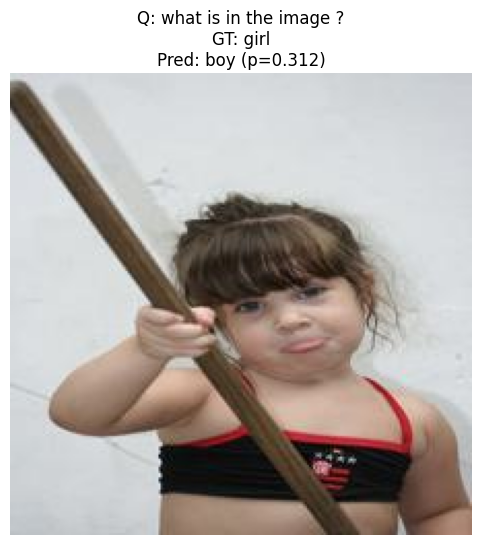

In [ ]:
import os

# folder where your images are stored
IMG_DIR = "/content/MyImages"

sample_row = val_df.sample(1).iloc[0]

# predict
pred, prob = predict_answer_for_image(
    model, image_features, question_tokenizer, idx2answer,
    sample_row['image'], sample_row['question'], max_q_len=max_q_len
)

# build full path
img_path = os.path.join(IMG_DIR, sample_row['image'])
img = mpimg.imread(img_path)

# show
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Q: {sample_row['question']}\nGT: {sample_row['answer']}\nPred: {pred} (p={prob:.3f})")
plt.show()
